In [28]:
# If you would like to install packages that are not installed by default, you may do so here.
# For example:

import sys
!{sys.executable} -m pip install --user currencyconverter

     |████████████████████████████████| 532 kB 4.6 MB/s eta 0:00:01


In [42]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from currency_converter import CurrencyConverter
from pandas.tseries.offsets import BDay

In [43]:
# Read dataset
df = pd.read_csv("credit_derivatives_trades.csv")

# Turn 'timestamp' into datetime for poseterior data manipulation. 
df["timestamp"] = pd.to_datetime(df["timestamp"], errors = "coerce")

# Rename the following column just for convenience.
df = df.rename(columns={'Unnamed: 0': 'idx'})

# Get only the business days (also excluding bank holidays, etc.).
#isBusinessDay = BDay().is_on_offset
#match_series = pd.to_datetime(df['timestamp']).map(isBusinessDay)
#df = df[match_series]

# For test, use a shorter time interval (1 month).
#d_range = pd.date_range(start=df.loc[0]["timestamp"], periods=2, freq='1M')
#mask = (df['timestamp'] >= d_range[0]) & (df['timestamp'] < d_range[1])
#df = df.loc[mask]
#df.reset_index(inplace=True, drop=True)

df

,idx,timestamp,notional,spread,ticker
0,0,2014-01-01 19:00:00,68000000,83.8750,ITXES5
1,1,2014-01-02 02:34:30,80000000,69.2500,ITXEB5
2,2,2014-01-02 02:37:14,13000000,69.5000,ITXEB5
3,3,2014-01-02 02:43:02,10000000,85.3750,ITXES5
4,4,2014-01-02 02:51:49,21000000,69.0000,ITXEB5
...,...,...,...,...,...
278021,278021,2017-09-28 15:38:37,50000000,56.9500,CDXIG5
278022,278022,2017-09-28 15:49:47,7000000,56.7225,CDXIG5
278023,278023,2017-09-28 16:01:53,110000000,56.7500,CDXIG5
278024,278024,2017-09-28 16:13:31,60000000,56.5500,CDXIG5


In [45]:
# Convert the notional for CDXIG5 from USD to EUR, so I can operate only in EUR. 
# But when some rates are missing (e.g., Easter Monday), I consider a linear interpolation
# Between the closest knonw values by setting 'fallback_on_missing_rate=True'.
c = CurrencyConverter(fallback_on_missing_rate=True)

#df[df.ticker=='CDXIG5'].index
for i in df[df.ticker=='CDXIG5'].index:
    df.loc[i, 'notional'] = c.convert(df.loc[i]['notional'], 'USD', 'EUR', date=df.loc[i]['timestamp'])
    df.loc[i, 'spread'] = c.convert(df.loc[i]['spread'], 'USD', 'EUR', date=df.loc[i]['timestamp'])
    
df

,idx,timestamp,notional,spread,ticker
0,0,2014-01-01 19:00:00,6.800000e+07,83.8750,ITXES5
1,1,2014-01-02 02:34:30,8.000000e+07,69.2500,ITXEB5
2,2,2014-01-02 02:37:14,1.300000e+07,69.5000,ITXEB5
3,3,2014-01-02 02:43:02,1.000000e+07,85.3750,ITXES5
4,4,2014-01-02 02:51:49,2.100000e+07,69.0000,ITXEB5
...,...,...,...,...,...
278021,278021,2017-09-28 15:38:37,4.245203e+07,56.9500,CDXIG5
278022,278022,2017-09-28 15:49:47,5.943284e+06,56.7225,CDXIG5
278023,278023,2017-09-28 16:01:53,9.339446e+07,56.7500,CDXIG5
278024,278024,2017-09-28 16:13:31,5.094244e+07,56.5500,CDXIG5


The approach adopted to solve this problem is based on the foward checking of trades to find a relative value trades. 

* The idea is that for every trade in the dataframe used as reference (starting from the very first one), given the time the operation was either performed or reported, one can check if any instrument is detected ahead of the reference one within a narrow time frame T (to be determined based on the knoledge about the reliability with respect to the real time of the operation). 

* If no instrument is detected within T one can say that no operation was performed. Thus, one can drop the reference instrument from the auxiliary data frame, and the next one in the stack will be now the reference starting with index 0. 

* If an instrument is detected within T, one can proceed with some additional checks. First of all, one can get the ticker corresponding to the reference point (top of the data frame). Next, one can get the other instrument based on the instrument of reference (CDXIG5/ITXEB5 or ITXEB5/ITXES5). From this point, one can get the rows corresponding to the time interval T such that the ticker is equal to the ticker for the relative value trade, and that the ratio between the notional and the reference notional is bounded and close to 1. In this regard, one can determine if some rows for the time interval T contains the expected values of both notional and the instrument in the operation, otherwise the reference value is dropped. On the other hand, if some calues satisfy the requirements, one should take the one with notional closer to the reference one.

In [70]:
# Create an auxiliary data frame. Rows corresponding to checked instruments will be dropped.
df_aux = df.copy(deep=True)

# Determine a lower and upper bound to validate an acceptable notional.
lower_notional_ratio = 0.9
upper_notional_ratio = 1.1

# time_trade will store the time instants of trades.
time_trade = [] # To store the time the trade occurred.
index_trade = [] # To read the trade in df.
boolean = True
while boolean:
    
    # Get the first row of the auxiliary data frame to be the reference point.
    trade_0 = df_aux.iloc[0]
    
    # Determine a narrow time window to check other intruments to detect operations with 
    # high probability.
    d_range = pd.date_range(start=trade_0["timestamp"], periods=2, freq='30min')
    t0 = d_range[0]
    t1 = d_range[1]
    mask = (df_aux['timestamp'] >= t0) & (df_aux['timestamp'] < t1)
    df_time = df_aux.loc[mask]
    
    ticker_ref = df_time.loc[0]["ticker"]
    nref = df_time.loc[0]["notional"]

    if ticker_ref == 'ITXES5':
        df_search = df_time[(df_time.ticker == 'ITXEB5') & 
                        (df_time.notional / nref > lower_notional_ratio) & 
                        (df_time.notional / nref < upper_notional_ratio)]

    else:

        if ticker_ref == 'ITXEB5':
            df_search = df_time[(df_time.ticker == 'ITXES5') &
                                (df_time.ticker == 'CDXIG5') &
                                (df_time.notional / nref > lower_notional_ratio) & 
                                (df_time.notional / nref < upper_notional_ratio)]
        else:
            df_search = df_time[(df_time.ticker == 'ITXEB5') &
                                (df_time.notional / nref > lower_notional_ratio) & 
                                (df_time.notional / nref < upper_notional_ratio)]

    if len(df_search) != 0:

        dnot = abs(df_time.notional[df_search.index]-nref)
        p_trade = dnot.idxmin()

        time_trade.append(df_time.loc[p_trade]["timestamp"])
        index_trade.append([df_time.loc[0]["idx"], df_time.loc[p_trade]["idx"]])
        
        df_aux = df_aux.drop(index=0)
        df_aux = df_aux.drop(index=p_trade)
        df_aux.reset_index(inplace=True, drop=True)

    else:
        df_aux = df_aux.drop(index=0)
        df_aux.reset_index(inplace=True, drop=True)

    #else:
    #    df_aux = df_aux.drop(index=0)
    #    df_aux.reset_index(inplace=True, drop=True)
    
    if len(df_aux)==1:
        boolean = False


In [71]:
# As the check in the previous cells takes a considerable amount of time I will save the outcome in the disk.
index_trade = np.array(index_trade)

time_trade_df=pd.DataFrame()
time_trade_df["timestamp"] = time_trade
time_trade_df["trade_0"] = index_trade[:, 0]
time_trade_df["trade_1"] = index_trade[:, 1]
time_trade_df.to_csv('time_trade.csv', header=["timestamp", "trade_0", "trade_1"])
time_trade_df

,timestamp,trade_0,trade_1
0,2014-01-02 05:22:49,33,35
1,2014-01-02 06:41:34,45,50
2,2014-01-02 08:15:14,66,72
3,2014-01-02 08:47:00,83,91
4,2014-01-02 08:39:45,86,89
...,...,...,...
25133,2017-09-28 10:12:42,277902,277909
25134,2017-09-28 10:32:16,277907,277928
25135,2017-09-28 10:18:34,277911,277916
25136,2017-09-28 10:45:12,277919,277934


##### Plot a spike each time a relative value trade (RVT) is identified.

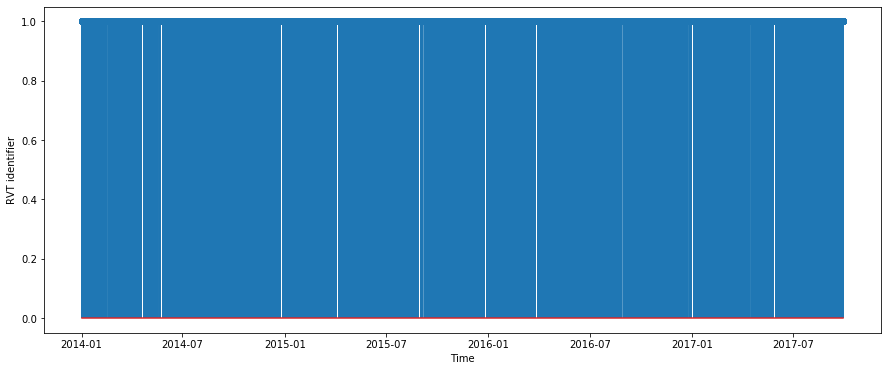

In [48]:
fig, ax = plt.subplots(1,figsize=(15, 6))
ax.stem(time_trade, np.ones(len(time_trade)), use_line_collection=True)
ax.set_xlabel('Time')
ax.set_ylabel('RVT identifier')
plt.show()

#### Daily information.

In [49]:
# Create a datframe with the stored date and time of the RVT operations presented in the previous graphic.

time_trade_df = pd.DataFrame(time_trade, columns=["timestamp"])
time_trade_df["timestamp"] = pd.to_datetime(time_trade_df["timestamp"], errors = "coerce")

# An extra column with ones is created for counting (not so elegant though!). 
time_trade_df["ones"] = np.ones(len(time_trade_df))

time_trade_df.head()

,timestamp,ones
0,2014-01-02 05:22:49,1.0
1,2014-01-02 06:41:34,1.0
2,2014-01-02 07:22:00,1.0
3,2014-01-02 07:56:02,1.0
4,2014-01-02 08:06:00,1.0


In [50]:
# Number of RVT per day. 

daily_trade = time_trade_df.resample('D', on='timestamp').ones.sum()

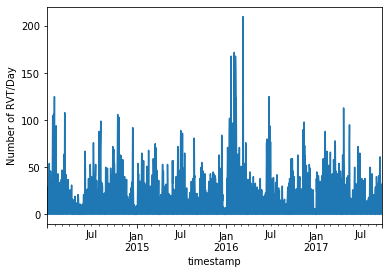

In [54]:
ax = daily_trade.plot()
ax.set_ylabel('Number of RVT/Day')
plt.show()

In [62]:
df_itxes5=df[df.ticker=="ITXES5"]
df_itxes5.reset_index(inplace=True, drop=True)
df_itxeb5=df[df.ticker=="ITXEB5"]
df_itxeb5.reset_index(inplace=True, drop=True)
df_cdxig5=df[df.ticker=="CDXIG5"]
df_cdxig5.reset_index(inplace=True, drop=True)

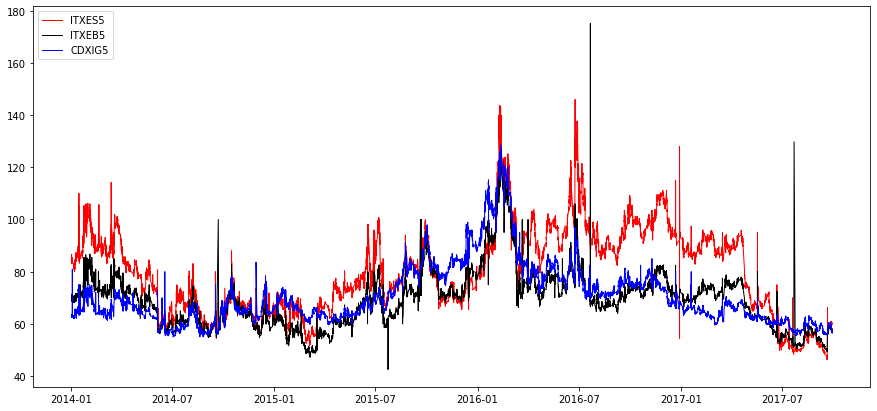

In [63]:
fig, ax = plt.subplots(1,figsize=(15, 7))
ax.plot(df_itxes5["timestamp"], df_itxes5["spread"].to_numpy(),'r', linewidth=1, label="ITXES5")
ax.plot(df_itxeb5["timestamp"], df_itxeb5["spread"].to_numpy(),'k', linewidth=1, label="ITXEB5")
ax.plot(df_cdxig5["timestamp"], df_cdxig5["spread"].to_numpy(),'b', linewidth=1, label="CDXIG5")
plt.legend(loc="upper left")
plt.show()